## Cargar datos de salarios DGII de Ene y Feb 2016

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from __future__ import division
from __future__ import print_function
from unidecode import unidecode
import re
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.style
#print(matplotlib.style.available)
#matplotlib.style.use('seaborn-colorblind')

df = pd.read_csv('cs_DGII_Nomina_2016.csv',sep=';')
print(df.shape)
print(df.columns)
df.head()

(5416, 5)
Index([u'Empleado', u' Salario ', u'Mes', u'Puesto', u'Genero'], dtype='object')


,Empleado,Salario,Mes,Puesto,Genero
0,JOANNY DEL CARMEN ACEVEDO MEDINA,"50,277.00",feb-16,Comprador(a),F
1,JOANNY DEL CARMEN ACEVEDO MEDINA,"50,277.00",ene-16,Comprador(a),F
2,EFRAIN EVANGELISTA DIAZ,"63,500.00",feb-16,Coordinador(a) Compras,M
3,EFRAIN EVANGELISTA DIAZ,"63,500.00",ene-16,Coordinador(a) Compras,M
4,JOHANNY DEL CARMEN RAMIREZ ROBLES,"50,277.00",feb-16,Comprador(a),F


Tenemos 5 columnas de datos. Incluyendo el género

En adición a cargar los datos realizamos una limpieza minima de los mismos para preparlos para el analisis. Esta consiste en:

* Convertir salarios de texto a montos
* Homogeneizar los puestos eliminando tildes, porciones entre parentesis, espacios en blanco de más y convirtiendo todas las letras a minusculas

In [2]:
def normalize_puesto(pstr):
    pstr = unidecode(unicode(pstr,'windows-1252')).strip().lower()
    pstr = re.sub('\(.*?\)','', pstr)
    return pstr


df.columns = [x.strip().translate(None,',').lower() for x in df.columns.values]
# parse salaries
df.salario = df.salario.apply(lambda x: x.translate(None,',').strip())
df.salario = df.salario.astype(float)
# cleanup puesto
df['puesto_clean'] = df.puesto.apply(normalize_puesto)
df.drop(['puesto'],axis=1,inplace=True)
df.rename(columns={'puesto_clean':'puesto'},inplace=True)
print(df.shape)

(5416, 5)


In [3]:
df.salario.describe()

count      5416.000000
mean      43711.412602
std       30802.706133
min        3502.070000
25%       24343.000000
50%       38946.000000
75%       51556.000000
max      559600.000000
Name: salario, dtype: float64

In [4]:
df['salariok'] = df.salario.div(1000).round(4)
df.salariok.describe()

count    5416.000000
mean       43.711413
std        30.802706
min         3.502100
25%        24.343000
50%        38.946000
75%        51.556000
max       559.600000
Name: salariok, dtype: float64

In [5]:
df.groupby(by='mes').salario.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
mes,,,,,,,,
ene-16,2703.0,43661.817984,30818.804953,3502.07,24057.5,38946.0,51556.0,559600.0
feb-16,2713.0,43760.824416,30792.260238,5679.00,24343.0,39045.0,51556.0,559600.0


In [6]:
ene = df[df.mes == 'ene-16']
feb = df[df.mes == 'feb-16']
print(ene.shape)
print(feb.shape)
print(ene.shape[0] + feb.shape[0])

(2703, 6)
(2713, 6)
5416


In [7]:
feb.salario.describe()

count      2713.000000
mean      43760.824416
std       30792.260238
min        5679.000000
25%       24343.000000
50%       39045.000000
75%       51556.000000
max      559600.000000
Name: salario, dtype: float64

In [8]:
print(feb.genero.value_counts())

F    1600
M    1113
Name: genero, dtype: int64


In [9]:
feb_by_gender = feb.groupby(by='genero')
feb_by_gender.salario.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
genero,,,,,,,,
F,1600.0,44827.896875,27224.643133,5679.00,28726.0,42333.0,53280.0,339730.0
M,1113.0,42226.847835,35251.273038,5722.67,20410.0,34774.0,51556.0,559600.0


In [10]:
print("\nProporción de empleomanía por genero")
print(feb_by_gender.salario.count().apply(lambda x: x/feb.salario.count()))
print("\nTotal nomina mensual por genero")
print(feb_by_gender.salario.sum())
print("\nProporcion de la nomina mensual por genero")
print(feb_by_gender.salario.sum().apply(lambda x: x/feb.salario.sum()))
print("\nDiferencia porcentual entre el salario promedio de mujeres y hombres")
print((feb_by_gender.salario.mean()[0]/feb_by_gender.salario.mean()[1] - 1)*100)


Proporción de empleomanía por genero
genero
F    0.589753
M    0.410247
Name: salario, dtype: float64

Total nomina mensual por genero
genero
F    71724635.00
M    46998481.64
Name: salario, dtype: float64

Proporcion de la nomina mensual por genero
genero
F    0.604134
M    0.395866
Name: salario, dtype: float64

Diferencia porcentual entre el salario promedio de mujeres y hombres
6.15970448588


Distribución de salarios por genero


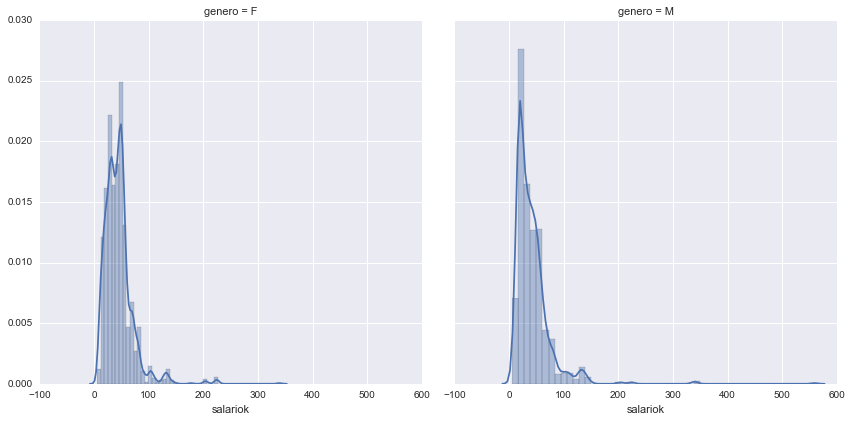

In [11]:
print("Distribución de salarios por genero")
g = sns.FacetGrid(data=feb, col='genero', size=6).map(sns.distplot,'salariok')

In [12]:
ene.puesto.nunique()

268

In [13]:
feb.puesto.nunique()

269

In [14]:
print(feb.puesto.value_counts().head(1))
print(ene.puesto.value_counts().head(1))

conserje    145
Name: puesto, dtype: int64
conserje    144
Name: puesto, dtype: int64


In [15]:
set(feb.puesto.unique()) - set(ene.puesto.unique())

{'disenador grafico'}

In [16]:
df[df.puesto == 'disenador grafico']

,empleado,salario,mes,genero,puesto,salariok
4300,FRANKLIN OMAR CASTILLO SEGURA,23593.5,feb-16,M,disenador grafico,23.5935


Como lo que nos interesa analizar es el salario que devengan hombres y mujeres por el mismo trabajo debemos procurar comparar solo aquellos que tienen el mismo puesto.

Asi que tomamos los registros pertenecientes a puestos con 30 personas o mas y al menos 1 hombre y 1 mujer.

In [17]:
spg = feb.groupby(by=['puesto']).filter(lambda x: len(x) > 14 and len(x[x.genero == 'F']) > 0 and len(x[x.genero == 'M']) > 0)
spg.puesto.value_counts()

conserje                                            145
oficial ctrl contrib a                               80
auditor interno a                                    70
tasador                                              63
oficial ctrl contrib c                               57
encargado unidad c                                   57
encargado seccion                                    54
auxiliar archivo                                     52
auditor externo c                                    50
analista                                             49
auxiliar informacion y atencion al contribuyente     49
auditor interno c                                    48
auxiliar                                             47
auditor externo b                                    46
oficial de gestion de fiscalizacion                  40
abogado b                                            36
oficial ctrl contrib b                               35
tec gestion servicios b                         

In [18]:
print(spg.puesto.nunique())
print(spg.puesto.value_counts().sum())
spg.groupby(by='genero').salario.describe().unstack()

50
1714


,count,mean,std,min,25%,50%,75%,max
genero,,,,,,,,
F,1122.0,41986.275401,20719.173661,5679.0,27214.0,42333.0,51556.0,133047.0
M,592.0,41318.456081,23539.918300,9525.0,20410.0,38946.0,51556.0,133047.0


In [19]:
pd.pivot_table(data=spg,values='salario',index=['puesto'],columns=['genero'],aggfunc=np.mean)

genero,F,M
puesto,,
abogado a,60629.863636,59639.000000
abogado b,52469.806452,51731.800000
abogado local a,46974.785714,49251.800000
abogado local c,34311.555556,33535.875000
administrador local c,133046.800000,131947.090909
analista,52175.571429,53802.857143
analista programador,65286.000000,59949.214286
analista recursos humanos,52287.800000,50277.000000
archivista,20410.000000,20410.000000


In [20]:
pivot_pg = pd.pivot_table(data=spg,values='salario',index=['puesto'],columns=['genero'],aggfunc=np.mean).apply(lambda x: x/x[1] - 1, axis=1)
pivot_pg.sort_values('F',inplace=True)

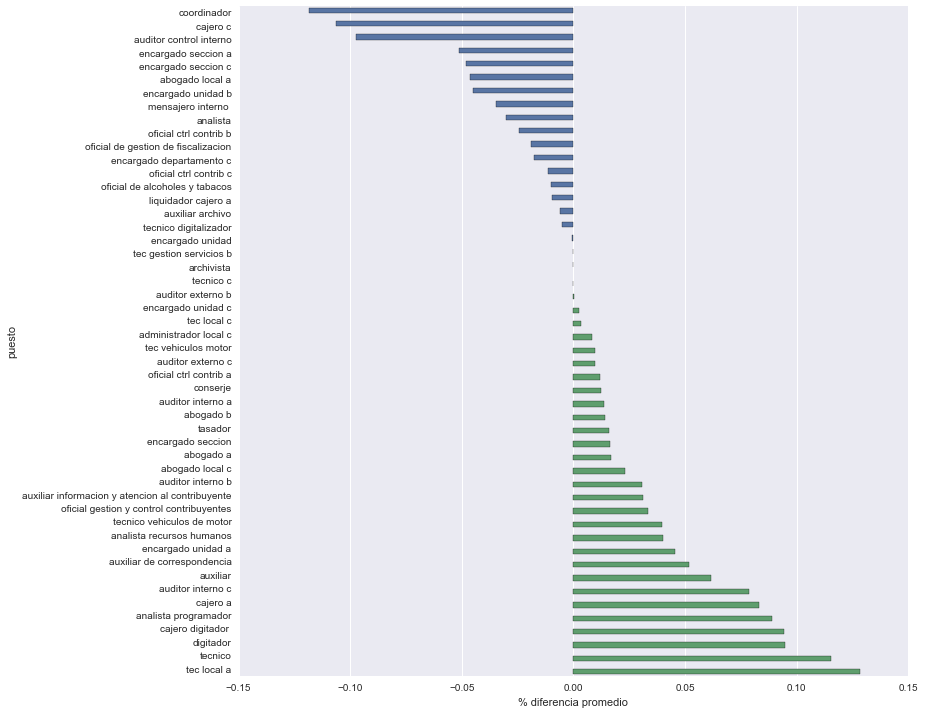

In [21]:
pivot_pg_plot_data = pivot_pg.copy()
pivot_pg_plot_data['positive'] = pivot_pg_plot_data.F.map(lambda x: x>0)
pivot_pg_plot_data.sort_values('F',inplace=True)
f = plt.figure(figsize=(12,12))
ax = sns.barplot(data=pivot_pg_plot_data,y=pivot_pg.index,x='F',hue='positive',orient='h')
ax.set_xlabel('% diferencia promedio')
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.legend().remove()

In [22]:
print(pivot_pg.mean())
print(pivot_pg_plot_data.positive.value_counts())

genero
F    0.009863
M    0.000000
dtype: float64
True     30
False    20
Name: positive, dtype: int64


In [23]:
pivot_pg.idxmin()

genero
F    coordinador
M    coordinador
dtype: object

In [24]:
spg[spg.puesto == 'encargado seccion c'].groupby(by='genero').salario.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
genero,,,,,,,,
F,16.0,66099.125,2961.635424,61845.0,61846.0,68032.0,68033.0,68033.0
M,15.0,69450.800,12676.654354,42333.0,61846.0,68032.0,72129.5,92800.0


In [25]:
pivot_pg.idxmax()

genero
F    tec local a
M    coordinador
dtype: object

In [26]:
spg[spg.puesto == 'auditor interno c'].groupby(by='genero').salario.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
genero,,,,,,,,
F,27.0,43396.888889,6538.628257,38946.0,38946.0,42841.0,42842.0,63681.0
M,21.0,40234.238095,3756.731783,27214.0,38946.0,38946.0,42842.0,46566.0


In [27]:
bottom25 = feb[feb.salario <= feb.salario.quantile(.25)]
top25 = feb[feb.salario >= feb.salario.quantile(.75)]
bottom25_by_gender = bottom25.groupby(by='genero')
bottom25_by_gender.salario.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
genero,,,,,,,,
F,312.0,17443.849359,4122.426443,5679.00,12620.0,20342.0,20410.0,24343.0
M,383.0,18227.821514,3018.836078,5722.67,17291.0,18871.0,20410.0,24343.0


In [28]:
top25_by_gender = top25.groupby(by='genero')
top25_by_gender.salario.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
genero,,,,,,,,
F,463.0,73666.892009,32255.190131,51556.0,55304.0,63195.0,80037.0,339730.0
M,289.0,80961.093426,48936.807545,51556.0,55304.0,65411.0,83154.0,559600.0


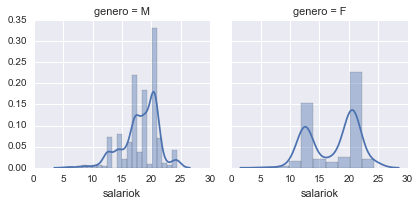

In [29]:
sns.FacetGrid(data=bottom25, col='genero').map(sns.distplot,'salariok')

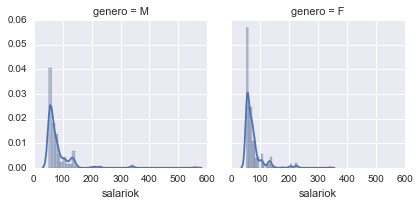

In [30]:
sns.FacetGrid(data=top25, col='genero').map(sns.distplot,'salariok')

In [31]:
print(bottom25_by_gender.salario.count())
print(bottom25_by_gender.salario.count().apply(lambda x: x/bottom25.salario.count()))
print(bottom25_by_gender.salario.sum())
print(bottom25_by_gender.salario.sum().apply(lambda x: x/bottom25.salario.sum()))

genero
F    312
M    383
Name: salario, dtype: int64
genero
F    0.448921
M    0.551079
Name: salario, dtype: float64
genero
F    5442481.00
M    6981255.64
Name: salario, dtype: float64
genero
F    0.438071
M    0.561929
Name: salario, dtype: float64


In [32]:
print(top25_by_gender.salario.count())
print(top25_by_gender.salario.count().apply(lambda x: x/top25.salario.count()))
print(top25_by_gender.salario.sum())
print(top25_by_gender.salario.sum().apply(lambda x: x/top25.salario.sum()))

genero
F    463
M    289
Name: salario, dtype: int64
genero
F    0.615691
M    0.384309
Name: salario, dtype: float64
genero
F    34107771.0
M    23397756.0
Name: salario, dtype: float64
genero
F    0.593122
M    0.406878
Name: salario, dtype: float64


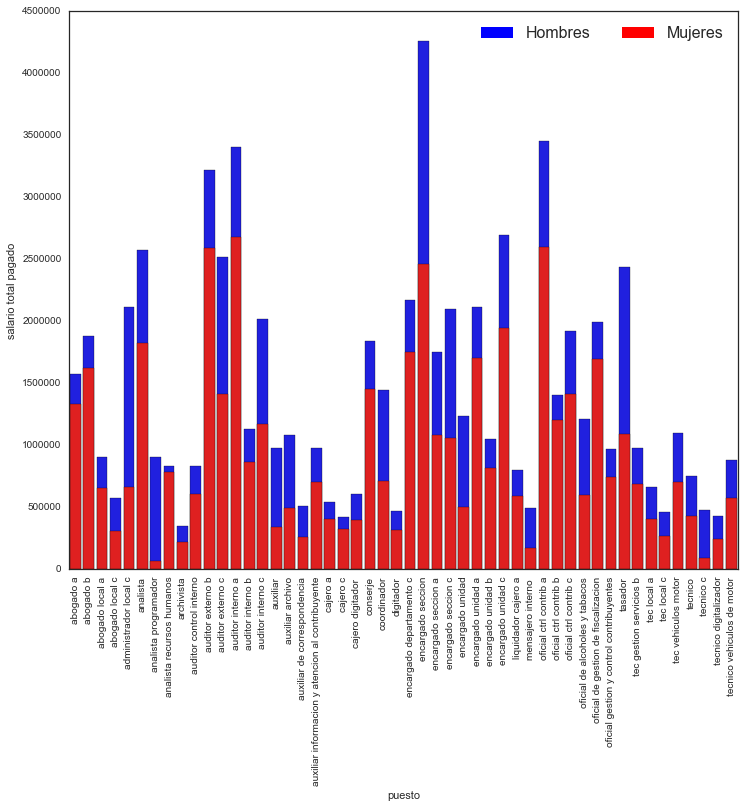

In [33]:
sns.set_style("white")
sns.set_context({"figure.figsize": (12, 10)})
# generar lista del total de salarios pagados por puesto
spg_salario_total = spg.groupby(by='puesto').salario.sum()
# generar lista de salario pagado a mujeres y hombres por puesto
spg_salario_f = spg[spg.genero == 'F'].groupby(by='puesto').salario.sum()
spg_salario_m = spg[spg.genero == 'M'].groupby(by='puesto').salario.sum()
# dibujar el total de salario por puesto en azul
salario_m_plot = sns.barplot(x=spg_salario_total.index, y=spg_salario_total, color ='blue')
# superponer el total de salario de mujeres por puesto en rojo
salario_f_plot = sns.barplot(x=spg_salario_total.index, y=spg_salario_f, color='red')
# girar los nombres de los puestos 90 grados para que esten verticales y sean legibles
for i in salario_f_plot.get_xticklabels():
    i.set_rotation(90)
salario_f_plot.set_ylabel('salario total pagado')
#
topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='blue',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Hombres', 'Mujeres'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

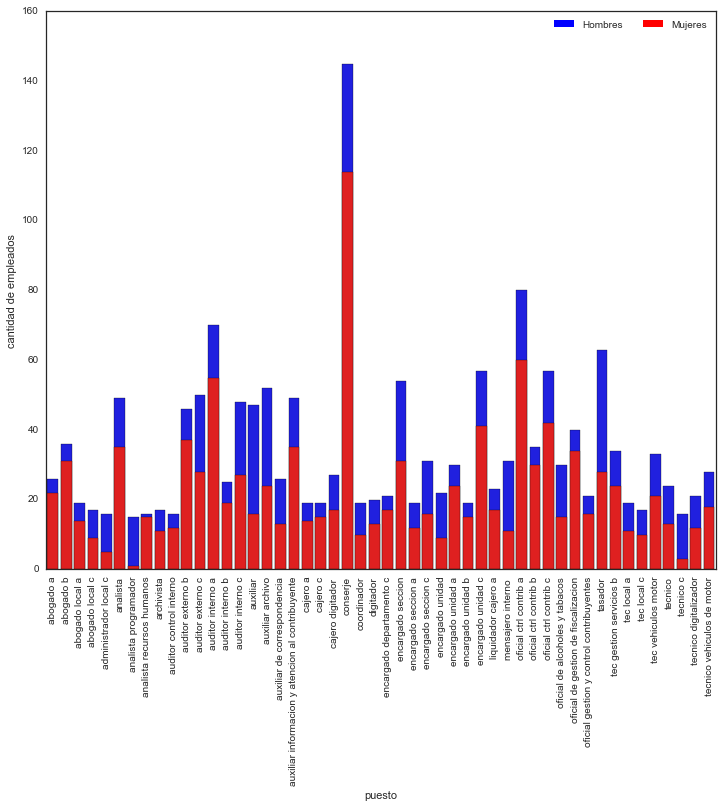

In [34]:
sns.set_style("white")
sns.set_context({"figure.figsize": (12, 10)})
# generar lista del total de empleados por puesto
spg_puesto_total = spg.groupby(by='puesto').salario.count()
# generar lista empleados mujeres y hombres por puesto
spg_puesto_f = spg[spg.genero == 'F'].groupby(by='puesto').salario.count()
spg_puesto_m = spg[spg.genero == 'M'].groupby(by='puesto').salario.count()
# dibujar el total de empleados por puesto en azul
salario_m_plot = sns.barplot(x=spg_puesto_total.index, y=spg_puesto_total, color ='blue')
# superponer el total de empleadas (mujeres) por puesto en rojo
salario_f_plot = sns.barplot(x=spg_puesto_total.index, y=spg_puesto_f, color='red')
# girar los nombres de los puestos 90 grados para que esten verticales y sean legibles
for i in salario_f_plot.get_xticklabels():
    i.set_rotation(90)
salario_f_plot.set_ylabel('cantidad de empleados')
#
topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='blue',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Hombres', 'Mujeres'], loc=1, ncol = 2)
l.draw_frame(False)

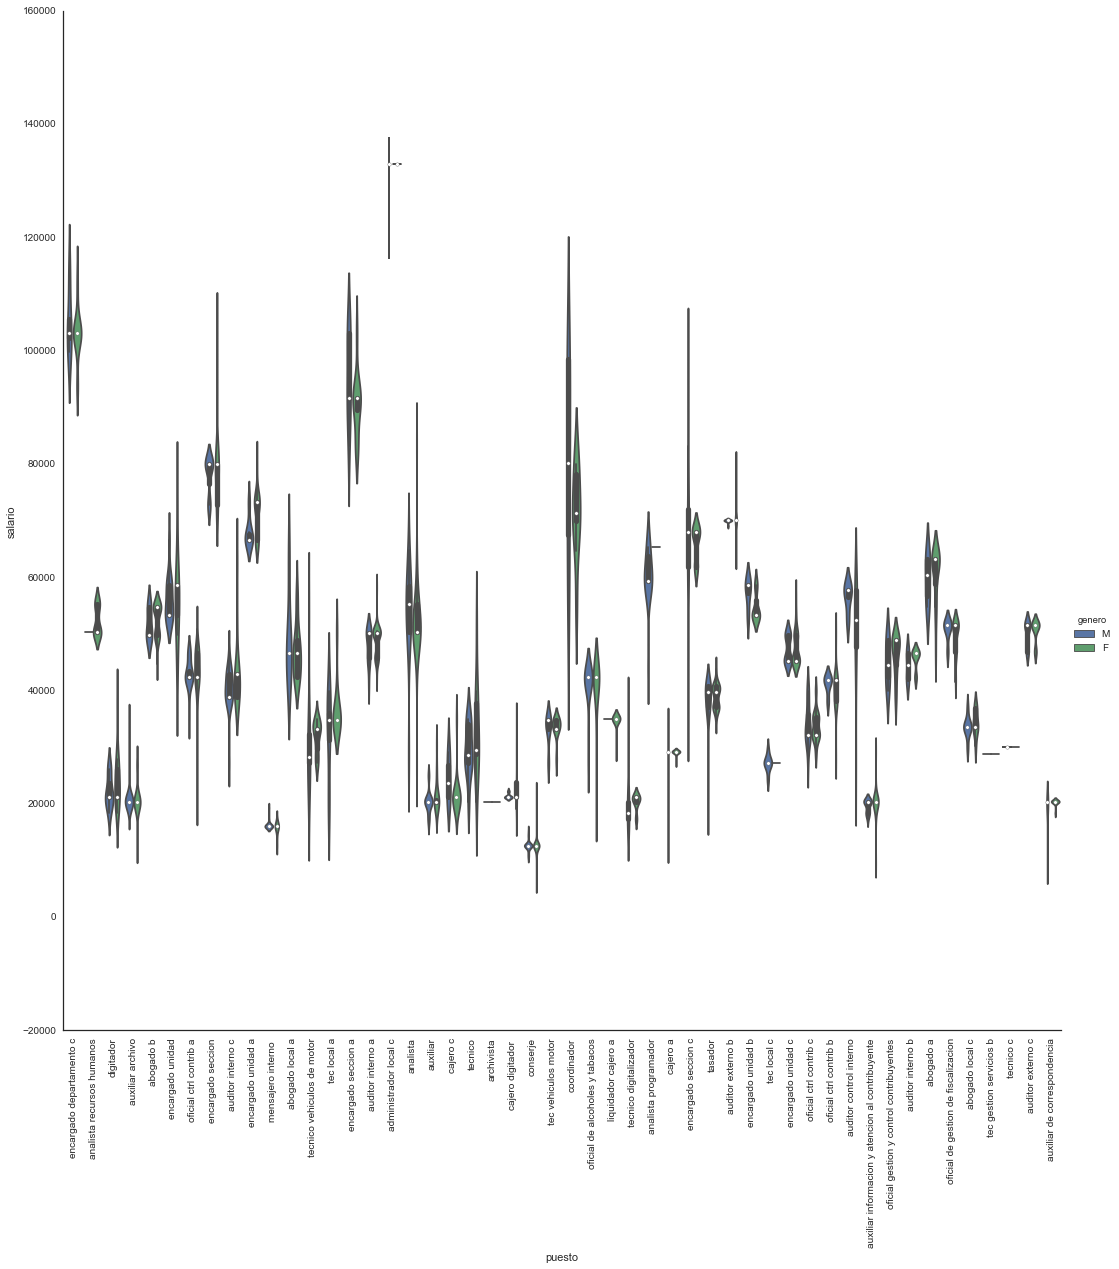

In [35]:
ax = sns.factorplot(data=spg,x='puesto',y='salario',hue='genero',kind='violin', size=15)
ax.set_xticklabels(rotation=90)

In [36]:
pd.pivot_table(data=top25,index=['puesto'],columns=['genero'],values='salario',aggfunc=np.mean).dropna().apply(lambda x: x/x[1] - 1,axis=1).mean()

genero
F   -0.006759
M    0.000000
dtype: float64

In [37]:
pd.pivot_table(data=bottom25,index=['puesto'],columns=['genero'],values='salario',aggfunc=np.mean).dropna().apply(lambda x: x/x[1] - 1,axis=1).mean()

genero
F    0.030548
M    0.000000
dtype: float64

24343.0
39045.0
51556.0


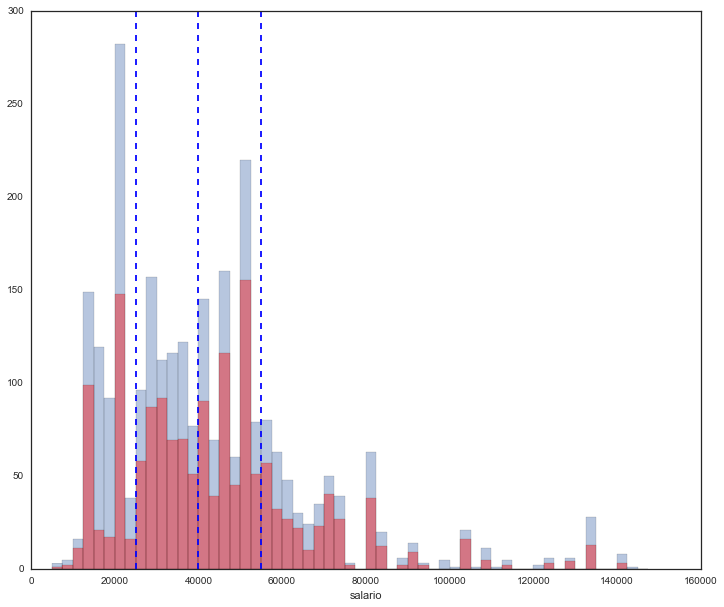

In [38]:
bins = range(5000,150000,2500)
ax = sns.distplot(feb.salario, kde=False, bins=bins)
sns.distplot(feb.salario[feb.genero == 'F'], kde=False, color='red', bins=bins)
print(feb.salario.quantile(.25))
print(feb.salario.quantile(.5))
print(feb.salario.quantile(.75))
plt.axvline(25000,linestyle='dashed')
plt.axvline(40000,linestyle='dashed')
plt.axvline(55000,linestyle='dashed')

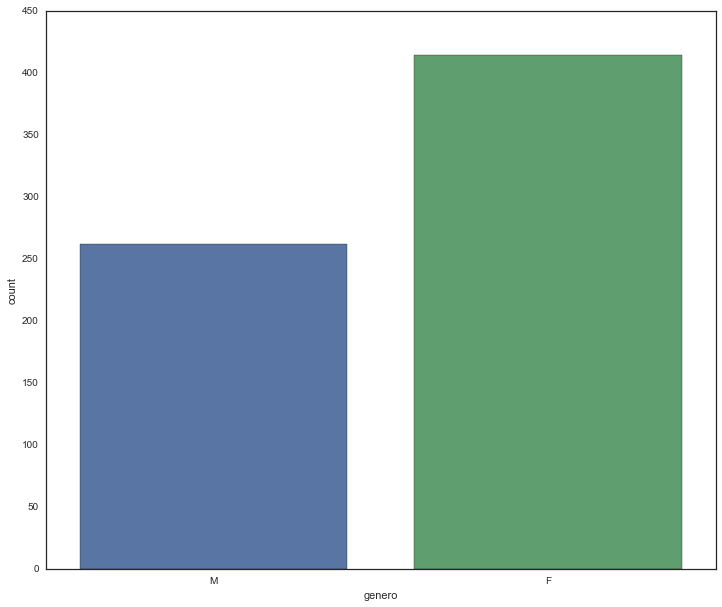

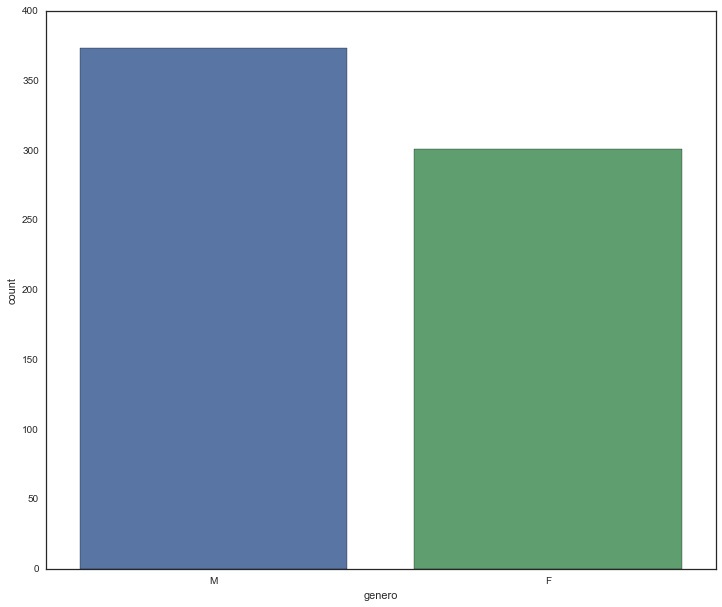

In [39]:
ax = sns.countplot(x='genero',data=feb[feb.salario > feb.salario.quantile(.75)])
plt.figure()
ax = sns.countplot(x='genero',data=feb[feb.salario < feb.salario.quantile(.25)])

In [40]:
import scipy.stats as stats
def mwu(f,m):
    try:
        u, p = stats.mannwhitneyu(f,m)
    except:
        u, p = (float('NaN'),float('Nan'))
    return p*2
        
spg.groupby(by='puesto').apply(lambda x: mwu(x[x.genero=='F'].salario,x[x.genero=='M'].salario)).sort_values()

puesto
analista                                            0.045805
tecnico digitalizador                               0.063719
cajero c                                            0.081361
analista programador                                0.086001
tecnico vehiculos de motor                          0.095356
encargado unidad b                                  0.095799
encargado unidad a                                  0.097349
auditor interno b                                   0.105842
auxiliar                                            0.131909
auditor interno c                                   0.150828
auxiliar informacion y atencion al contribuyente    0.151458
coordinador                                         0.174085
auditor externo b                                   0.200190
auditor control interno                             0.214211
tecnico                                             0.218553
mensajero interno                                   0.233091
oficial ctrl cont

In [41]:
spg[spg.puesto == 'analista'].groupby(by='genero').salario.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
genero,,,,,,,,
F,35.0,52175.571429,7740.927887,27214.0,50277.0,50277.0,55304.0,83250.0
M,14.0,53802.857143,8520.495073,28717.0,50277.0,55304.0,58374.0,64860.0


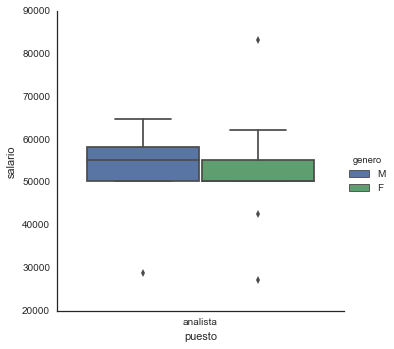

In [42]:
sns.factorplot(data=spg[spg.puesto=='analista'],x='puesto',y='salario',hue='genero',kind='box', size=5)

In [43]:
rspg = spg.copy()
rspg.genero = np.random.permutation(rspg.genero)
rspg[rspg.puesto == 'analista'].groupby(by='genero').salario.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
genero,,,,,,,,
F,37.0,53081.27027,8652.780332,27214.0,50277.0,50277.0,55304.0,83250.0
M,12.0,51281.50000,5071.484550,42721.0,50277.0,50277.0,50277.0,64860.0


In [44]:
rpivot_pg = pd.pivot_table(data=rspg,values='salario',index=['puesto'],columns=['genero'],aggfunc=np.mean).apply(lambda x: x/x[1] - 1, axis=1)
rpivot_pg.sort_values('F',inplace=True)

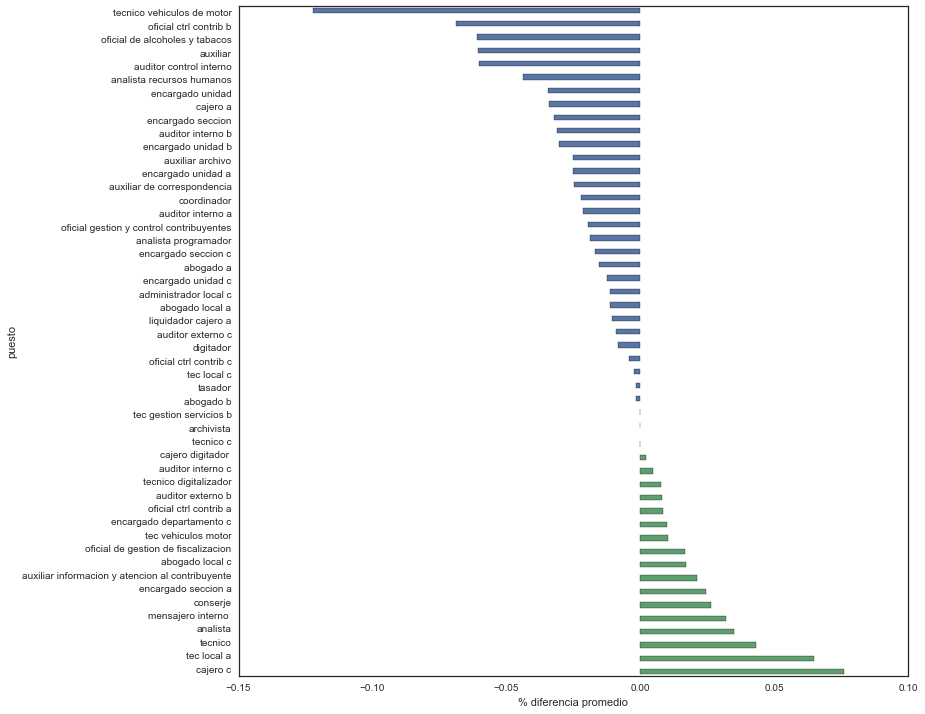

In [45]:
rpivot_pg_plot_data = rpivot_pg.copy()
rpivot_pg_plot_data['positive'] = rpivot_pg_plot_data.F.map(lambda x: x>0)
rpivot_pg_plot_data.sort_values('F',inplace=True)
f = plt.figure(figsize=(12,12))
ax = sns.barplot(data=rpivot_pg_plot_data,y=rpivot_pg.index,x='F',hue='positive',orient='h')
ax.set_xlabel('% diferencia promedio')
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.legend().remove()

In [87]:
bins = range(5000,150000,2500)
feb['salario_bin'] = pd.qcut(feb.salario,10,precision=0)
feb.salario_bin.value_counts()
epg_count = pd.pivot_table(data=feb,index=['salario_bin'],columns=['genero'],values='salario',aggfunc=len).apply(lambda x: x/x.sum() * 100,axis=1)
epg_sum = pd.pivot_table(data=feb,index=['salario_bin'],columns=['genero'],values='salario',aggfunc=np.sum).apply(lambda x: x/x.sum() * 100,axis=1)

C:\Users\Dario\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


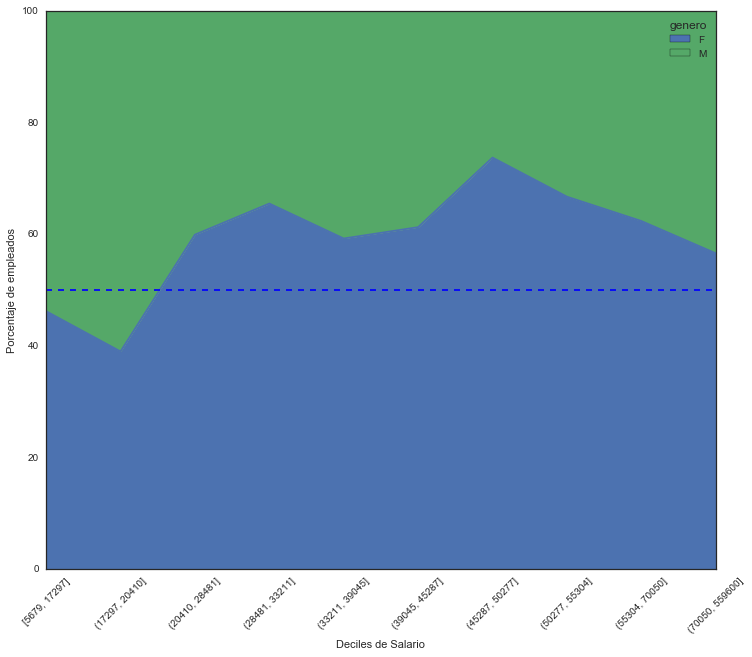

In [135]:
ax = epg_count.plot(kind='area',stacked=True, grid=True)
ax.set_xlabel('Deciles de Salario')
ax.set_ylabel('Porcentaje de empleados')
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.axhline(50,linestyle='dashed')

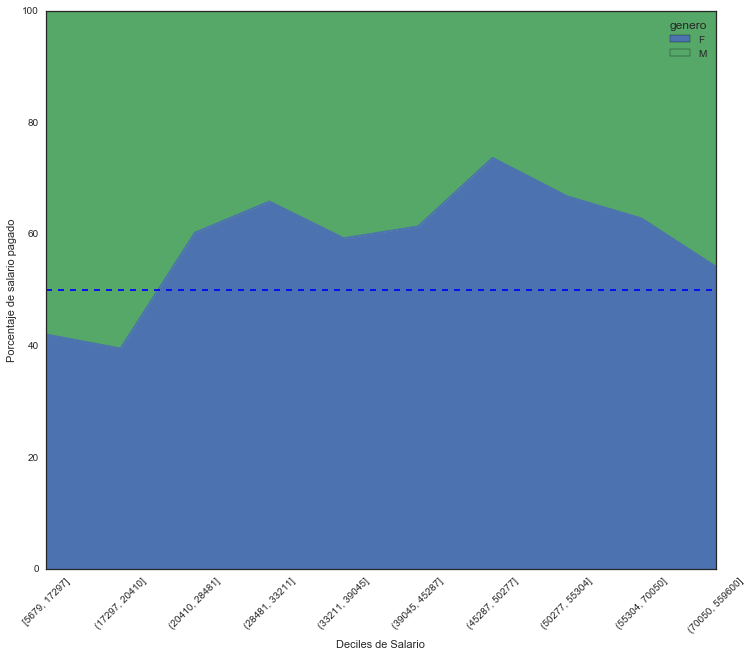

In [134]:
ax = epg_sum.plot(kind='area',stacked=True)
ax.set_xlabel('Deciles de Salario')
ax.set_ylabel('Porcentaje de salario pagado')
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.axhline(50,linestyle='dashed')